In [9]:
import pandas as pd
import numpy as np
from fredapi import Fred
from config import key, pwrd
from tqdm import tqdm, tqdm_notebook
import warnings
import time
from sqlalchemy import create_engine
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [10]:
#SQL connect to local database
# rds_connection_string = "postgres:"+ pwrd + "@localhost:5432/astoria"
# engine = create_engine(f'postgresql://{rds_connection_string}')

In [11]:
#define FRED API call
fred = Fred(api_key= key)

In [12]:
#set column view options
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 50)

In [13]:
# Code to search FRED database
# search = fred.search('500', order_by='popularity', sort_order='desc')
# search_df = pd.DataFrame(search[['title', 'id', 'popularity', 'units','seasonal_adjustment_short']])
# search_df[:20]

In [14]:
#desired indicators
indicators = ['USSLIND', 'UMCSENT', 'CSCICP03USM665S', 'INDPRO', 'TCU','DGORDER', 'NEWORDER', 'PI','BUSINV', 'TOTALSA',
             'MARTSMPCSM44X72USS', 'PAYEMS', 'UNRATE', 'ICSA', 'CCSA', 'CC4WSA', 'NPPTTL', 'CES0500000003', 'HSN1F',
             'EXHOSLUSM495S', 'PERMIT', 'CSUSHPINSA', 'SP500']

In [15]:
print(f'{len(indicators)} indicators to download')

23 indicators to download


In [47]:
#create FRED dataframe function
def fred_df(series):
    data =  fred.get_series(series, observation_start= '04/01/2010')
    info = fred.get_series_info(series)
    data_df = pd.DataFrame(data)
    data_df.reset_index(level=0, inplace=True)
    info_df = pd.DataFrame(info)
    info_df.reset_index(level=0, inplace=True)
    #pivot info_df
    df_dict = dict(zip(info_df['index'],info_df[0]))
    info_df = pd.DataFrame(df_dict,  index=[0])
    #duplicate info_df rows to equal data_df length
    info_df = pd.concat([info_df]*(len(data_df)), ignore_index=True)
    #join df's
    combine_df = data_df.join(info_df)
    #rename columns
    combine_df.rename(columns = {'index':'date', 0:'data'}, inplace = True) 
    #create new 'change from last column'
    combine_df.insert(2, 'change', np.nan)
    #fill nan with zeroes
    combine_df['change'].fillna(0, inplace=True)
    #create data for 'change' column
    changes = [combine_df.iloc[i,1]-combine_df.iloc[i-1,1] for i in range (1,len(combine_df))]
    change_clean = [float("{0:.3f}".format(x)) for x in changes]
    combine_df['change'][1:len(combine_df)] = change_clean
    #create pct_change column
    combine_df.insert(3,'pct_change',np.nan)
    #fill nan with zeroes
    combine_df['pct_change'].fillna(0, inplace=True)
    #create data for pct_change col
    pct_change = [combine_df.iloc[i,1]/combine_df.iloc[i-1,1] - 1 *100 for i in range(1,len(spx_df))]
    pct_clean = [float("{0:.3f}".format(x)) for x in pct_change]
    combine_df['pct_change'][1:len(combine_df)] = pct_clean
    combine_df.to_csv(f"data/{indicator}.csv",index = False, header = True)

In [48]:
#function to create dataframe and csv's for each indicator
errors=[]
for indicator in tqdm_notebook(indicators):
    try:
        #get data and info series
        fred_df(indicator)
        combine_df.to_csv(f"data/{indicator}.csv",index = False, header = True)
        #export data to SQL
#         combine_df.to_sql(name= indicator, con=engine, if_exists='replace', index=True)
        time.sleep(0.2)
        print(f'{indicator} retrieved')
    except: 
        print(f'error with {indicator} data. Proceeding...')
        errors.append(indicator)
        

error with USSLIND data. Proceeding...
error with UMCSENT data. Proceeding...
error with CSCICP03USM665S data. Proceeding...
error with INDPRO data. Proceeding...
error with TCU data. Proceeding...
error with DGORDER data. Proceeding...
error with NEWORDER data. Proceeding...
error with PI data. Proceeding...
error with BUSINV data. Proceeding...
error with TOTALSA data. Proceeding...
error with MARTSMPCSM44X72USS data. Proceeding...
error with PAYEMS data. Proceeding...
error with UNRATE data. Proceeding...
error with ICSA data. Proceeding...
error with CCSA data. Proceeding...
error with CC4WSA data. Proceeding...
error with NPPTTL data. Proceeding...
error with CES0500000003 data. Proceeding...
error with HSN1F data. Proceeding...
error with EXHOSLUSM495S data. Proceeding...
error with PERMIT data. Proceeding...
error with CSUSHPINSA data. Proceeding...
SP500 retrieved



In [44]:
fred_df('SP500', '3/08/2010')

In [46]:
test = 'SP500'


SyntaxError: can't assign to literal (<ipython-input-46-685bd804d8ef>, line 2)

In [45]:
combine_df

,date,data,change,pct_change,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
0,2010-04-07,1182.45,0.00,0.000,SP500,2020-04-07,2020-04-07,S&P 500,2010-04-07,2020-04-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2020-04-06 19:10:55-05,87,The observations for the S&P 500 represent the...
1,2010-04-08,1186.44,3.99,0.337,SP500,2020-04-07,2020-04-07,S&P 500,2010-04-07,2020-04-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2020-04-06 19:10:55-05,87,The observations for the S&P 500 represent the...
2,2010-04-09,1194.37,7.93,0.668,SP500,2020-04-07,2020-04-07,S&P 500,2010-04-07,2020-04-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2020-04-06 19:10:55-05,87,The observations for the S&P 500 represent the...
3,2010-04-12,1196.48,2.11,0.177,SP500,2020-04-07,2020-04-07,S&P 500,2010-04-07,2020-04-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2020-04-06 19:10:55-05,87,The observations for the S&P 500 represent the...
4,2010-04-13,1197.30,0.82,0.069,SP500,2020-04-07,2020-04-07,S&P 500,2010-04-07,2020-04-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2020-04-06 19:10:55-05,87,The observations for the S&P 500 represent the...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2604,2020-03-31,2584.59,-42.06,-1.601,SP500,2020-04-07,2020-04-07,S&P 500,2010-04-07,2020-04-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2020-04-06 19:10:55-05,87,The observations for the S&P 500 represent the...
2605,2020-04-01,2470.50,-114.09,-4.414,SP500,2020-04-07,2020-04-07,S&P 500,2010-04-07,2020-04-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2020-04-06 19:10:55-05,87,The observations for the S&P 500 represent the...
2606,2020-04-02,2526.90,56.40,2.283,SP500,2020-04-07,2020-04-07,S&P 500,2010-04-07,2020-04-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2020-04-06 19:10:55-05,87,The observations for the S&P 500 represent the...
2607,2020-04-03,2488.65,-38.25,-1.514,SP500,2020-04-07,2020-04-07,S&P 500,2010-04-07,2020-04-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2020-04-06 19:10:55-05,87,The observations for the S&P 500 represent the...


In [ ]:
#create spx dataframe

#get data and info series
data =  fred.get_series('SP500', observation_start='3/08/2010')
info = fred.get_series_info('SP500')
data_df = pd.DataFrame(data)
data_df.reset_index(level=0, inplace=True)
info_df = pd.DataFrame(info)
info_df.reset_index(level=0, inplace=True)
#pivot info_df
df_dict = dict(zip(info_df['index'],info_df[0]))
info_df = pd.DataFrame(df_dict,  index=[0])
#duplicate info_df rows to equal data_df length
info_df = pd.concat([info_df]*(len(data_df)), ignore_index=True)
#join df's
spx_df = data_df.join(info_df)
#rename columns
spx_df.rename(columns = {'index':'date', 0:'data'}, inplace = True) 
#create new 'change from last column'
spx_df.insert(2, 'change', np.nan)
#fill nan with zeroes
spx_df['change'].fillna(0, inplace=True)
#create data for 'change' column
changes = [spx_df.iloc[i,1]-spx_df.iloc[i-1,1] for i in range (1,len(spx_df))]
change_clean = [float("{0:.3f}".format(x)) for x in changes]
spx_df['change'][1:len(spx_df)] = change_clean
#create pct_change column
spx_df.insert(3,'pct_change',np.nan)
#fill nan with zeroes
spx_df['pct_change'].fillna(0, inplace=True)
#create data for pct_change col
pct_change = [spx_df.iloc[i,1]/spx_df.iloc[i-1,1] - 1 *100 for i in range(1,len(spx_df))]
pct_clean = [float("{0:.3f}".format(x)) for x in pct_change]
spx_df['pct_change'][1:len(spx_df)] = pct_clean

In [39]:
#function to create dataframe and csv's for each indicator
errors=[]
for indicator in tqdm_notebook(indicators):
    try:
         #get data and info series
        data = fred.get_series(indicator, observation_start='1/31/1990')
        info = fred.get_series_info(indicator)
        #store as df's and reset indexes 
        data_df = pd.DataFrame(data)
        data_df.reset_index(level=0, inplace=True)
        info_df = pd.DataFrame(info)
        info_df.reset_index(level=0, inplace=True)
        #pivot info_df
        df_dict = dict(zip(info_df['index'],info_df[0]))
        info_df = pd.DataFrame(df_dict,  index=[0])
        #duplicate info_df rows to equal data_df length
        info_df = pd.concat([info_df]*(len(data_df)), ignore_index=True)
        #join df's
        combine_df = data_df.join(info_df)
        #rename columns
        combine_df.rename(columns = {'index':'date', 0:'data'}, inplace = True) 
        #create new 'change from last column'
        combine_df.insert(2, 'change', np.nan)
        #fill nan with zeroes
        combine_df['change'].fillna(0, inplace=True)
        #create data for 'change' column
        changes = [combine_df.iloc[i,1]-combine_df.iloc[i-1,1] for i in range (1,len(combine_df))]
        change_clean = [float("{0:.3f}".format(x)) for x in changes]
        combine_df['change'][1:len(combine_df)] = change_clean
        #create pct_change column
        combine_df.insert(3,'pct_change',np.nan)
        #fill nan with zeroes
        combine_df['pct_change'].fillna(0, inplace=True)
        #create data for pct_change col
        pct_change = [(combine_df.iloc[i,1]/combine_df.iloc[i-1,1] - 1) *100 for i in range(1,len(combine_df))]
        pct_clean = [float("{0:.3f}".format(x)) for x in pct_change]
        combine_df['pct_change'][1:len(combine_df)] = pct_clean
        #write to csv
        combine_df.to_csv(f"data/{indicator}.csv",index = False, header = True)
        #export data to SQL
#         combine_df.to_sql(name= indicator, con=engine, if_exists='replace', index=True)
        time.sleep(0.2)
        print(f'{indicator} retrieved')
    except: 
        print(f'error with {indicator} data. Proceeding...')
        errors.append(indicator)
        
    

USSLIND retrieved
UMCSENT retrieved
CSCICP03USM665S retrieved
INDPRO retrieved
TCU retrieved
DGORDER retrieved
NEWORDER retrieved
PI retrieved
BUSINV retrieved
TOTALSA retrieved
MARTSMPCSM44X72USS retrieved
PAYEMS retrieved
UNRATE retrieved
ICSA retrieved
CCSA retrieved
CC4WSA retrieved
NPPTTL retrieved
CES0500000003 retrieved
HSN1F retrieved
EXHOSLUSM495S retrieved
PERMIT retrieved
CSUSHPINSA retrieved
SP500 retrieved



In [40]:
combine_df.head()

,date,data,change,pct_change,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
0,2010-04-07,1182.45,0.00,0.000,SP500,2020-04-07,2020-04-07,S&P 500,2010-04-07,2020-04-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2020-04-06 19:10:55-05,87,The observations for the S&P 500 represent the...
1,2010-04-08,1186.44,3.99,0.337,SP500,2020-04-07,2020-04-07,S&P 500,2010-04-07,2020-04-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2020-04-06 19:10:55-05,87,The observations for the S&P 500 represent the...
2,2010-04-09,1194.37,7.93,0.668,SP500,2020-04-07,2020-04-07,S&P 500,2010-04-07,2020-04-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2020-04-06 19:10:55-05,87,The observations for the S&P 500 represent the...
3,2010-04-12,1196.48,2.11,0.177,SP500,2020-04-07,2020-04-07,S&P 500,2010-04-07,2020-04-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2020-04-06 19:10:55-05,87,The observations for the S&P 500 represent the...
4,2010-04-13,1197.30,0.82,0.069,SP500,2020-04-07,2020-04-07,S&P 500,2010-04-07,2020-04-06,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2020-04-06 19:10:55-05,87,The observations for the S&P 500 represent the...


## fredapi Examples
s = fred.get_series('SP500', observation_start='1/31/2014')
info = fred.get_series_info('PAYEMS')
info['title']
df = fred.search_by_category(101, limit=10, order_by='popularity', sort_order='desc')
df['title']
more info at https://mortada.net/python-api-for-fred.html

In [20]:
#create spx dataframe

#get data and info series
data =  fred.get_series('SP500', observation_start='3/08/2010')
info = fred.get_series_info('SP500')
data_df = pd.DataFrame(data)
data_df.reset_index(level=0, inplace=True)
info_df = pd.DataFrame(info)
info_df.reset_index(level=0, inplace=True)
#pivot info_df
df_dict = dict(zip(info_df['index'],info_df[0]))
info_df = pd.DataFrame(df_dict,  index=[0])
#duplicate info_df rows to equal data_df length
info_df = pd.concat([info_df]*(len(data_df)), ignore_index=True)
#join df's
spx_df = data_df.join(info_df)
#rename columns
spx_df.rename(columns = {'index':'date', 0:'data'}, inplace = True) 
#create new 'change from last column'
spx_df.insert(2, 'change', np.nan)
#fill nan with zeroes
spx_df['change'].fillna(0, inplace=True)
#create data for 'change' column
changes = [spx_df.iloc[i,1]-spx_df.iloc[i-1,1] for i in range (1,len(spx_df))]
change_clean = [float("{0:.3f}".format(x)) for x in changes]
spx_df['change'][1:len(spx_df)] = change_clean
#create pct_change column
spx_df.insert(3,'pct_change',np.nan)
#fill nan with zeroes
spx_df['pct_change'].fillna(0, inplace=True)
#create data for pct_change col
pct_change = [spx_df.iloc[i,1]/spx_df.iloc[i-1,1] - 1 *100 for i in range(1,len(spx_df))]
pct_clean = [float("{0:.3f}".format(x)) for x in pct_change]
spx_df['pct_change'][1:len(spx_df)] = pct_clean


In [ ]:
spx_df.head(10)

In [22]:

data = fred.get_series('PAYEMS', observation_start='3/29/2010')
info = fred.get_series_info('PAYEMS')
#store as df's and reset indexes 
data_df = pd.DataFrame(data)
data_df.reset_index(level=0, inplace=True)
info_df = pd.DataFrame(info)
info_df.reset_index(level=0, inplace=True)
#pivot info_df
df_dict = dict(zip(info_df['index'],info_df[0]))
info_df = pd.DataFrame(df_dict,  index=[0])
#duplicate info_df rows to equal data_df length
info_df = pd.concat([info_df]*(len(data_df)), ignore_index=True)
#join df's
combine_df = data_df.join(info_df)
#rename columns
combine_df.rename(columns = {'index':'date', 0:'data'}, inplace = True) 
#create new 'change from last column'
combine_df.insert(2, 'change', np.nan)
#fill nan with zeroes
combine_df['change'].fillna(0, inplace=True)
#create data for 'change' column
changes = [combine_df.iloc[i,1]-combine_df.iloc[i-1,1] for i in range (1,len(combine_df))]
change_clean = [float("{0:.3f}".format(x)) for x in changes]
combine_df['change'][1:len(combine_df)] = change_clean



In [37]:
#function to make charts monthly and plot monthly change
def monthly(df):
    #make date col the index
    df = df.reset_index().set_index('date')
    #resample df to Monthly Business freq, take last value
    df = df.resample('BM').last()
    #reset index
    df.reset_index(level=0, inplace=True)
    #drop old change, pct_change and index 
    df.drop(['change','pct_change', 'index'], axis=1, inplace=True)
    #re-calc change and pct_change
    #create new 'change from last column'
    df.insert(2, 'change', np.nan)
    #fill nan with zeroes
    df['change'].fillna(0, inplace=True)
    #create data for 'change' column
    changes = [df.iloc[i,1]-df.iloc[i-1,1] for i in range (1,len(df))]
    change_clean = [float("{0:.3f}".format(x)) for x in changes]
    df['change'][1:len(df)] = change_clean
    #create pct_change column
    df.insert(3,'pct_change',np.nan)
    #fill nan with zeroes
    df['pct_change'].fillna(0, inplace=True)
    #create data for pct_change col
    pct_change = [(df.iloc[i,1]/df.iloc[i-1,1] - 1) * 10 for i in range(1,len(df))]
    pct_clean = [float("{0:.3f}".format(x)) for x in pct_change]
    df['pct_change'][1:len(df)] = pct_clean
    #change frequency
    df.replace({'frequency': 'Daily, Close'}, 'Monthly, Close', inplace=True)
    df.replace({'frequency_short': 'D'}, 'M', inplace=True)
    
    
#     plt.figure(figsize=(10,6))
#     plt.plot(df['date'],df[col], color = "blue", label = f'{df}')
    return df.head()
    
    
    

In [82]:
spx_df= spx_df.reset_index().set_index('date') 

In [103]:
spx_month_df = spx_df.resample('M').last()
spx_month_df.reset_index(level=0, inplace=True)
plt.plot(spx_month_df['date'],spx_month_df['data'], color = "blue", label = f'{df}')


In [104]:
spx_month_df.head()

,date,index,data,change,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
0,2010-03-31,2,1169.43,-3.84,SP500,2020-03-29,2020-03-29,S&P 500,2010-03-29,2020-03-27,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2020-03-27 19:10:58-05,87,The observations for the S&P 500 represent the...
1,2010-04-30,24,1186.69,-20.09,SP500,2020-03-29,2020-03-29,S&P 500,2010-03-29,2020-03-27,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2020-03-27 19:10:58-05,87,The observations for the S&P 500 represent the...
2,2010-05-31,45,1089.41,-13.65,SP500,2020-03-29,2020-03-29,S&P 500,2010-03-29,2020-03-27,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2020-03-27 19:10:58-05,87,The observations for the S&P 500 represent the...
3,2010-06-30,67,1030.71,-10.53,SP500,2020-03-29,2020-03-29,S&P 500,2010-03-29,2020-03-27,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2020-03-27 19:10:58-05,87,The observations for the S&P 500 represent the...
4,2010-07-31,89,1101.60,0.07,SP500,2020-03-29,2020-03-29,S&P 500,2010-03-29,2020-03-27,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2020-03-27 19:10:58-05,87,The observations for the S&P 500 represent the...


In [65]:
# #rename date col
# spx_month_df.rename(columns = {'date':'day'}, inplace = True) 
# # spx_month_df.drop(columns = ['date'], inplace=True)


In [ ]:
# spx_month_df['date'] = pd.to_datetime(spx_month_df['date'], format='%m-%Y').dt.strftime('%m-%Y')

In [49]:
pd.plotting.register_matplotlib_converters()

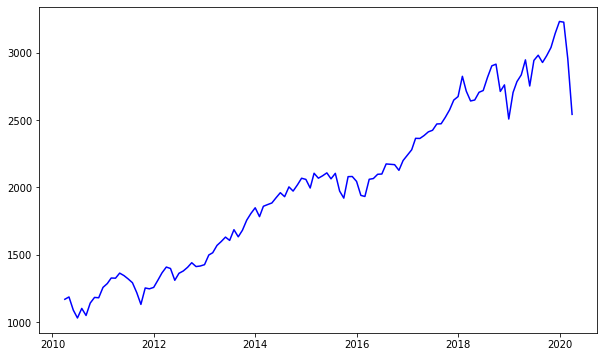

In [106]:
plt.figure(figsize=(10,6))
#creat mdate columns for plotting
# spx_month_df['mdate'] = [mdates.date2num(d) for d in spx_month_df['date']]
plt.plot(spx_month_df['date'],spx_month_df['data'], color = "blue", label="S&P 500")
# plt.plot(spx_month_df['date'],combine_month_df['change'], color = "red", label="NFP")
# plt.title("SPX vs NFP", fontsize=20)
# plt.xlabel("Star Rating", fontsize=16)
# plt.ylabel("Average", fontsize=16)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.legend(loc="best", fontsize=16)
plt.show()
# plt.savefig("images/game_total_help_ratio.png")
